In [9]:
import torch
import IPython
import torch.utils
import torch.distributions
import torchvision

import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch import nn

In [10]:
torch.manual_seed(0)
plt.rcParams['figure.dpi'] = 200

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
class Decoder(nn.Module):
  def __init__(self, latent_dims):
    super(Decoder, self).__init__()
    self.linear1 = nn.Linear(latent_dims, 512)
    self.linear2 = nn.Linear(512, 784)
  def forward(self, z):
    z = F.relu(self.linear1(z))
    z = torch.sigmoid(self.linear2(z))
    return z.reshape((-1, 1, 28, 28))

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        
        return self.decoder(z)

In [14]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)
    
    for epoch in range(epochs):
        for x, _ in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            loss.backward()
            opt.step()
    
    return autoencoder

In [15]:
class Encoder(nn.Module):
  def __init__(self, latent_dims):
      super(Encoder, self).__init__()
      self.linear1 = nn.Linear(784, 512)
      self.to_mean_logvar = nn.Linear(512, 2*latent_dims)

  def reparametrization_trick(self, mu, log_var):
      # Using reparameterization trick to sample from a gaussian
      eps = torch.randn_like(log_var)
      return mu + torch.exp(log_var / 2) * eps

  def forward(self, x):
      x = torch.flatten(x, start_dim=1)
      x = F.relu(self.linear1(x))
      mu, log_var = torch.split(self.to_mean_logvar(x),2, dim=-1)
      self.mu = mu
      self.var = log_var.exp()
      self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
      
      return self.reparametrization_trick(mu, log_var)

In [16]:
z_dim = 2
autoencoder = Autoencoder(z_dim).to(device) # GPU

data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data_loader, epochs=20)

In [17]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)        
        return self.decoder(z)

In [18]:
def train(vae, data, epochs=20):
    opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum') + vae.encoder.kl
            loss.backward()
            opt.step()
    return vae

In [19]:
vae = VariationalAutoencoder(z_dim).to(device) # GPU
vae = train(vae, data_loader, epochs=20)

In this part we compare between sampling from the standard normal distribution with the mu and sigma after encoding and the distribution with noise.

             Original            Standard            With Noise


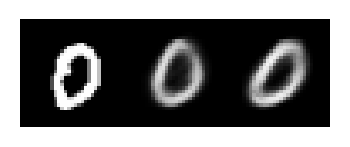

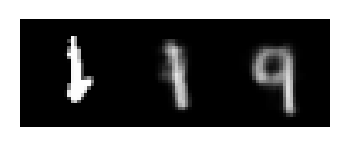

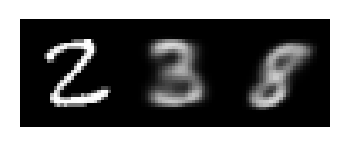

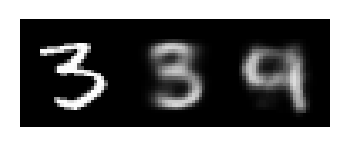

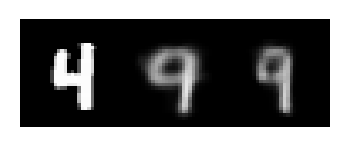

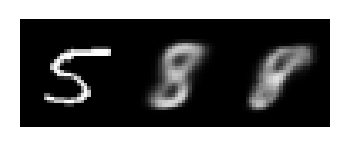

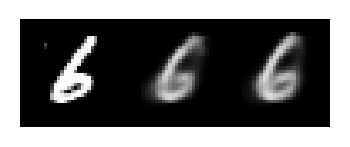

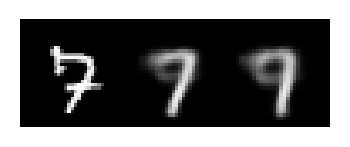

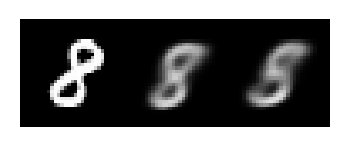

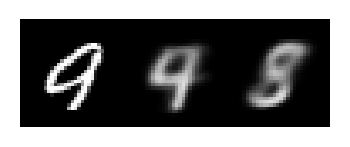

In [37]:
print('             Original            Standard            With Noise')
for digit in range(10):
    for x, y in data_loader:
        y_in_digit = [cur for cur in y if cur == digit]
        sample_index = random.choice((y == digit).nonzero())
        x_sample = x[sample_index]
        break
    
    vae.encoder(x_sample)
    mu = vae.encoder.mu
    var = vae.encoder.var
    img = []
    img.append(x_sample)
    img.append(vae.decoder(mu))
    noise = (torch.rand(2) - 0.5) * 2
    random_variable = torch.randn(2) * torch.sqrt(var) + mu + noise
    z = random_variable.to(device)
    x_hat = vae.decoder(z)
    img.append(x_hat)
    img = torch.cat(img)
    img = torchvision.utils.make_grid(img,nrow=12).permute(1, 2, 0).detach().numpy()
    plt.figure(figsize=(2, 2))
    plt.imshow(img.squeeze())
    plt.axis('off')
    plt.show()


Assuming that images represing the same number will be close to each other. Therefore given an image of number, sampaling image from the expection of the original image + noise will shift the mass center. Thus, if the new expection will be quite diffrent from the original expection we will get images with greater variance. The effect of this phenomenon clearly reflected from the results. Another phenomenon worth discussing is the fact the numbers with distinct shapes are less effected from the noise.

In this part we explore the effect of the sigma on the distributions and the process in general.

sigma:      0.1              1                   10                  100


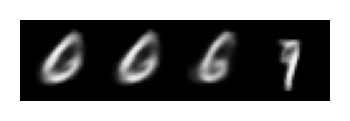

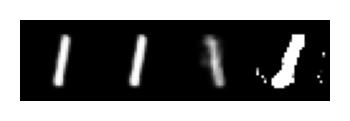

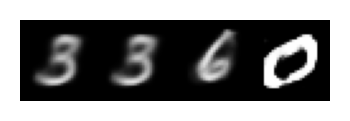

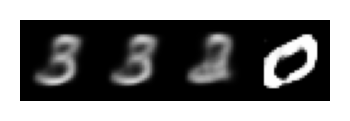

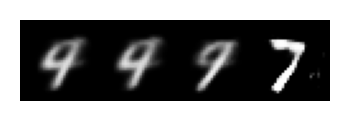

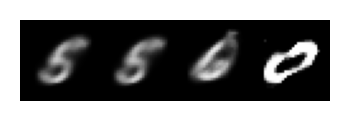

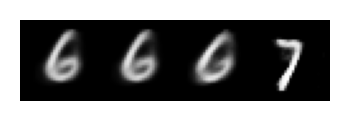

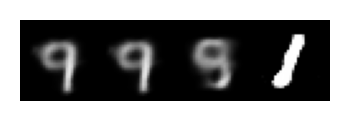

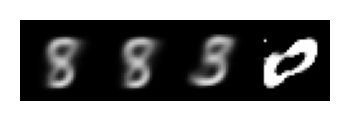

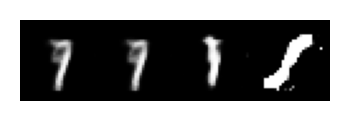

In [70]:
print('sigma:      0.1              1                   10                  100')

for digit in range(10):
  for x, y in data_loader:
      y_in_digit = [cur for cur in y if cur == digit]
      sample_index = random.choice((y == digit).nonzero())
      x_sample = x[sample_index]
      break

  vae.encoder(x_sample)

  mu = vae.encoder.mu
  var = vae.encoder.var

  img = []

  std_range = [0.1, 1, 10, 100]
  for factor in std_range:
      random_variable = torch.randn(2) * torch.sqrt(var) * factor + mu
      z = random_variable.to(device)
      x_hat = vae.decoder(z)
      img.append(x_hat)

  img = torch.cat(img)
  img = torchvision.utils.make_grid(img,nrow=12).permute(1, 2, 0).detach().numpy()
  plt.figure(figsize=(2, 2))
  plt.imshow(img.squeeze())
  plt.axis('off')
    

The value of σ control the amount that deviation from the expectation of a certain number will still be classified as the number. For low values we will not deviate much, so the images are quite like the original number. As the value rises, determining the distribution which the image got sampled from is getting much harder.

In [71]:
def plot_latent(autoencoder, data, num_batches=100):
  for i, (x, y) in enumerate(data):
    z = autoencoder.encoder(x.to(device))
    z = z.to('cpu').detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
    if i > num_batches:
      plt.colorbar()
      break

def train_kl(vae, data, epochs=20):
  opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
  for epoch in range(epochs):
    for x, y in data:
      x = x.to(device) # GPU
      opt.zero_grad()
      x_hat = vae(x)
      loss = vae.encoder.kl
      loss.backward()
      opt.step()
  return vae

def train_prob_x_given_z(vae, data, epochs=20):
  opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
  for epoch in range(epochs):
    for x, y in data:
      x = x.to(device) # GPU
      opt.zero_grad()
      x_hat = vae(x)
      loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
      loss.backward()
      opt.step()
  return vae


In [72]:
vae_kl = VariationalAutoencoder(z_dim).to(device)
vae_kl = train_kl(vae_kl, data_loader)

The loss function of VAE is:

![picture](https://i.imgur.com/nQVz0Cj.png)

So in order to see the efect of each part I will train by each part sepratily and watch the effect on the results:

In [73]:
vae_prob_x_given_z = VariationalAutoencoder(z_dim).to(device)
vae_prob_x_given_z = train_prob_x_given_z(vae_prob_x_given_z, data_loader)

 D_KL (qθ (z|x)||pθ (z)) - The effect of this part is creating generalization and getting the distribution closer to normal distribution. So I expect that training only by this part will result in normal like result.

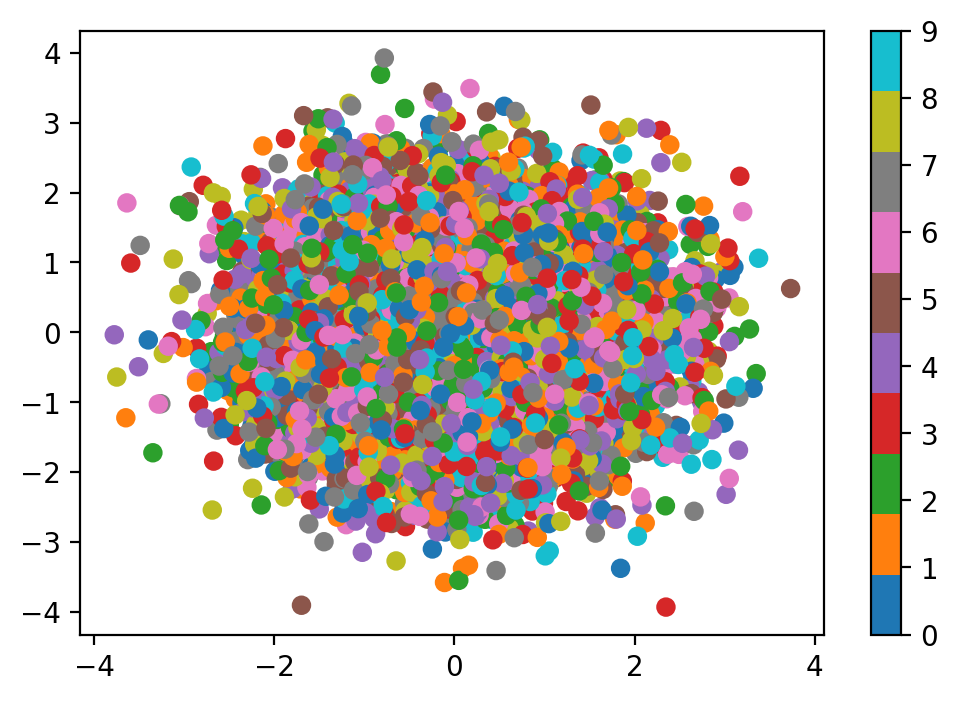

In [74]:
plot_latent(vae_kl, data_loader, num_batches=100)

As we can see the result indeed is normal distribution like.

Ez [log⁡(pθ (X|z))]- This expression part is to lower the distance between the distribution of the latent variables and the real distribution. So training only based on this expression I'm expecting to see convergence to the autoencoder and see disinct dection areas for each number

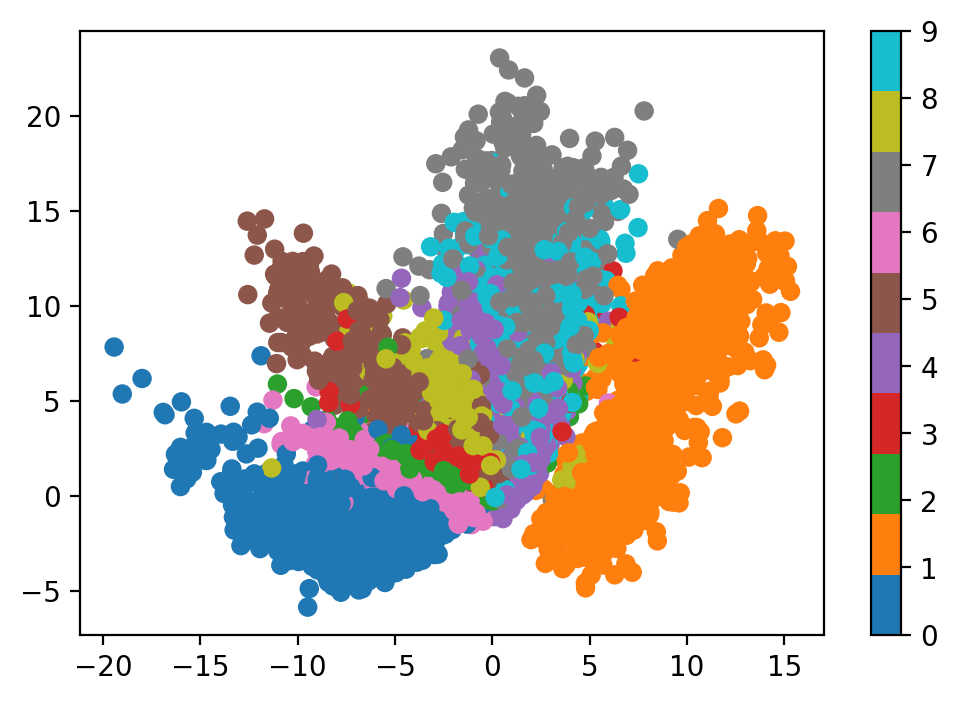

In [75]:
plot_latent(vae_prob_x_given_z, data_loader, num_batches=100)

As we can see, indeed decision area was created as expected.